In [1]:
#Import neccary libraries 
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


# Nasdaq Composite

### **Import the dataset and basic statistics**

In [212]:
# read the CSV file into a DataFrame - Data Ranges from Nov 25 2010 - nov 26 2023
df = pd.read_csv("IXIC.csv")
df_nasdaq = df

In [3]:
#obtain basic statistics of the dataset
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3.271000e+03
mean,7205.895654,7253.862421,7153.326814,7207.008784,7207.008784,2.783468e+09
std,3860.958811,3892.202380,3825.598025,3860.563132,3860.563132,1.449546e+09
min,2312.679932,2397.340088,2298.889893,2335.830078,2335.830078,2.214300e+08
25%,4141.764892,4161.199951,4125.185058,4146.014892,4146.014892,1.795720e+09
50%,6149.549805,6164.939941,6110.669922,6146.620117,6146.620117,2.070970e+09
75%,10599.859863,10744.495117,10480.385254,10601.324707,10601.324707,3.975525e+09
max,16120.919922,16212.230469,16017.230469,16057.440430,16057.440430,1.162119e+10


### **Data-Preprocessing**

In [4]:
#create a dataframe using lcosing proces for modelling
close_prices = df[['Date','Adj Close']]
close_stock = close_prices.copy()
#transform features using minmax scaler 
del close_prices['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closep=scaler.fit_transform(np.array(close_prices).reshape(-1,1))
print(closep.shape)


(3271, 1)


In [5]:
#create training and testing size
training_size=int(len(closep)*0.75)
test_size=len(closep)-training_size
train_data,test_data=closep[0:training_size,:],closep[training_size:len(closep),:1]


In [6]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3-----99 100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [7]:
#create training and test datasets
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (2437, 15)
y_train:  (2437,)
X_test:  (802, 15)
y_test (802,)


### **K-Nearest Neighbours**

In [8]:
from sklearn.neighbors import KNeighborsRegressor

K = time_step
model = KNeighborsRegressor(n_neighbors=K)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [9]:
#  for KNN
# make predictions on training and test sets using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# reshape the predictions to match the shape of the target variables
train_predictions_reshaped = train_predictions.reshape(-1, 1)
test_predictions_reshaped = test_predictions.reshape(-1, 1)


In [10]:
# Converting to original form
train_predict = scaler.inverse_transform(train_predictions_reshaped)
test_predict = scaler.inverse_transform(test_predictions_reshaped)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [11]:
#calculating measure values for the model
print("KNN- Train RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("KNN- Train MSE: ", mean_squared_error(original_ytrain,train_predict))
print("KNN- Test RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("KNN- Test MSE: ", mean_squared_error(original_ytest,test_predict))
print("KNN- Train R2 score:", r2_score(original_ytrain, train_predict))
print("KNN- Test R2 score:", r2_score(original_ytest, test_predict))

KNN- Train RMSE:  96.109568196837
KNN- Train MSE:  9237.049098982463
KNN- Test RMSE:  2403.698015500437
KNN- Test MSE:  5777764.1497207405
KNN- Train R2 score: 0.9978329296552559
KNN- Test R2 score: -1.8245654629383017


Train predicted data:  (250, 1)
Test predicted data:  (250, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

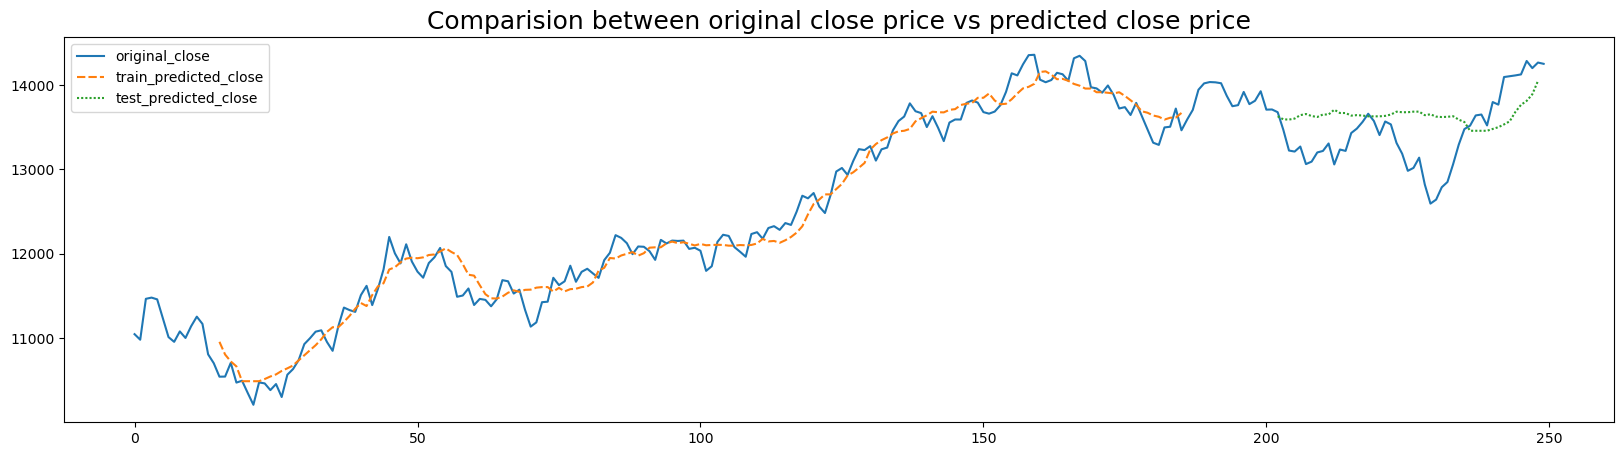

In [13]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

# **GRU**

In [12]:

print("X_train: ", X_train.shape) 
print("X_test: ", X_test.shape)


X_train:  (2437, 15)
X_test:  (802, 15)


In [13]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22401 (87.50 KB)
Trainable params: 22401 (87.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)

Epoch 1/10
488/488 [==============================] - 5s 7ms/step - loss: 9.3054e-04 - val_loss: 0.0088
Epoch 2/10
488/488 [==============================] - 3s 6ms/step - loss: 1.5005e-04 - val_loss: 0.0013
Epoch 3/10
488/488 [==============================] - 3s 6ms/step - loss: 1.0670e-04 - val_loss: 0.0010
Epoch 4/10
488/488 [==============================] - 3s 6ms/step - loss: 9.4725e-05 - val_loss: 0.0013
Epoch 5/10
488/488 [==============================] - 3s 6ms/step - loss: 7.7823e-05 - val_loss: 5.0970e-04
Epoch 6/10
488/488 [==============================] - 3s 6ms/step - loss: 8.6062e-05 - val_loss: 3.0098e-04
Epoch 7/10
488/488 [==============================] - 3s 6ms/step - loss: 7.7484e-05 - val_loss: 7.1984e-04
Epoch 8/10
488/488 [==============================] - 3s 6ms/step - loss: 7.4142e-05 - val_loss: 2.2049e-04
Epoch 9/10
488/488 [==============================] - 3s 6ms/step - loss: 6.5482e-05 - val_loss: 3.8642e-04
Epoch 10/10
488/488 [=======================

In [16]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train) 
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape


26/26 [==============================] - 0s 2ms/step


((2437, 1), (802, 1))

In [17]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict) 
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


In [18]:
# Evaluation metrices RMSE and MAE
print("	")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("	")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("	")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("	")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print("	")



	
Train data RMSE:  325.2219946518449
Train data MSE:  105769.34580532463
Test data MAE:  316.3208583885733
	
Test data RMSE:  615.3717362411231
Test data MSE:  378682.37376441446
Test data MAE:  574.4863878219295
	
Train data explained variance regression score: 0.9984832600742327
Test data explained variance regression score: 0.9754685324731972
	
Train data R2 score: 0.9751858401723829
Test data R2 score: 0.814874209704431
	


Train predicted data:  (3271, 1)
Test predicted data:  (3271, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

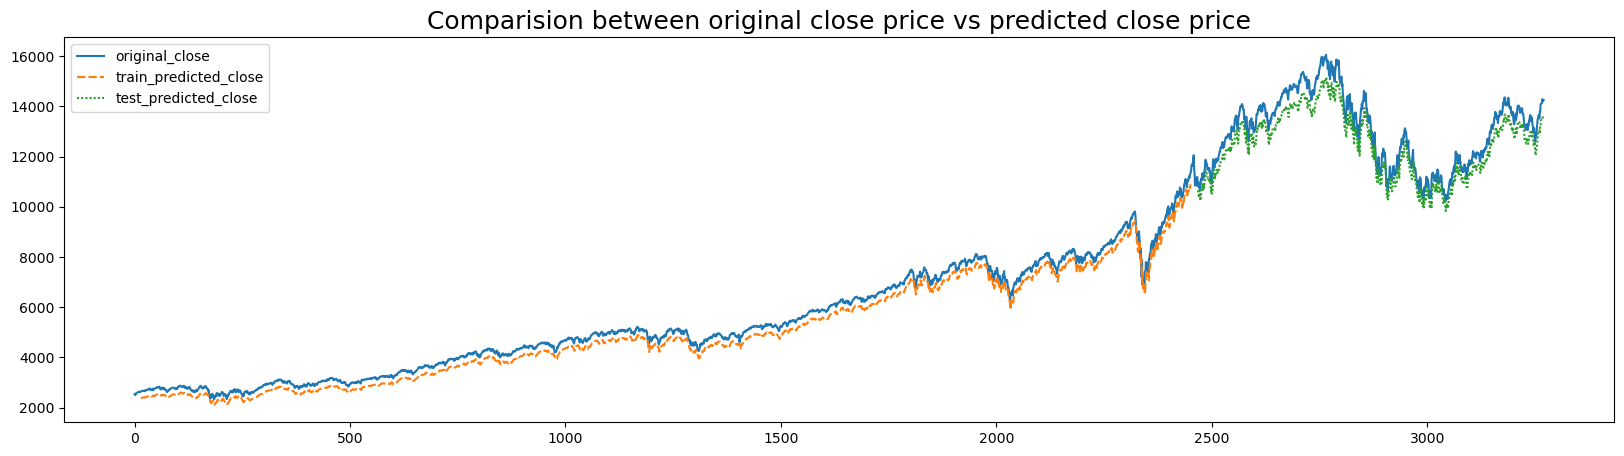

In [19]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **RFR**

In [20]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [21]:
# Lets Do the prediction
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (2437, 1)
Test data prediction: (802, 1)


In [22]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [23]:
# Evaluation metrices RMSE and MAE
print("---------------------------------------------------------------------------------------------------------")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


---------------------------------------------------------------------------------------------------------
Train data RMSE:  29.830312574901896
Train data MSE:  889.8475483163502
Test data MAE:  17.602707532720473
---------------------------------------------------------------------------------------------------------
Test data RMSE:  2217.9375992462865
Test data MSE:  4919247.194150381
Test data MAE:  1796.09958222774
---------------------------------------------------------------------------------------------------------
Train data explained variance regression score: 0.999791256181213
Test data explained variance regression score: 0.09689994529418533
---------------------------------------------------------------------------------------------------------
Train data R2 score: 0.9997912361174401
Test data R2 score: -1.404863779170511


Train predicted data:  (3271, 1)
Test predicted data:  (3271, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

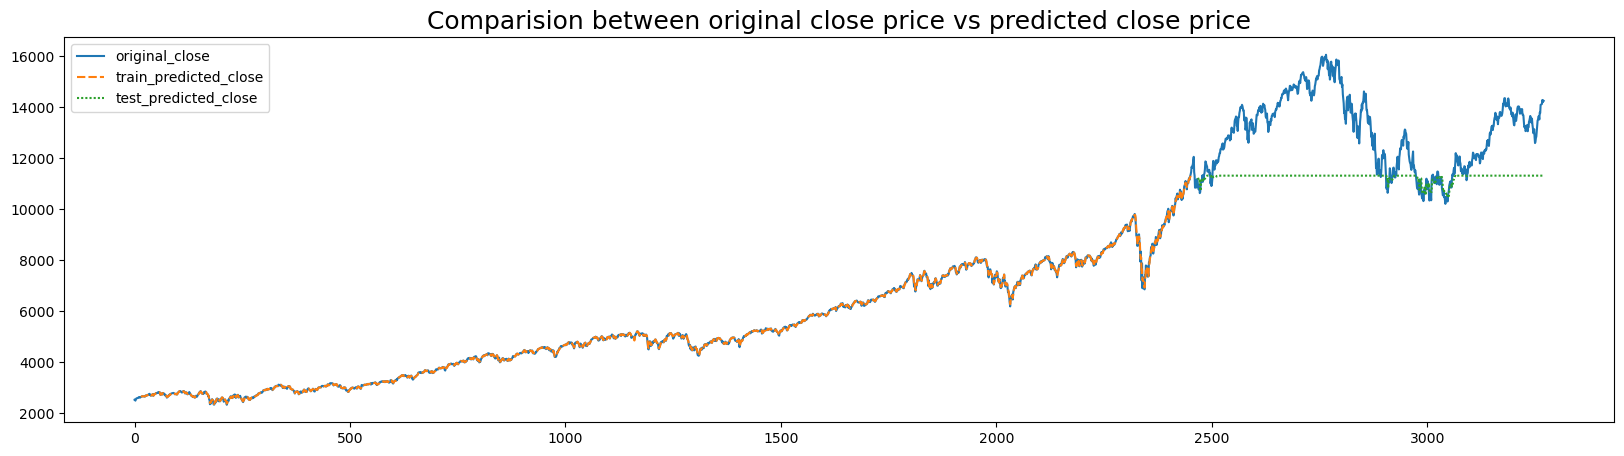

In [24]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

In [25]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler




### **LSTM**

In [26]:
#reshape (samples, time steps, features)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")



X_train: (2437, 15, 1)
X_test: (802, 15, 1)


In [27]:
#summary

model.summary()

#epoch model fit

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


#Prediction

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
488/488 [==============================] - 4s 5ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 2/10
488/488 [==============================] 

In [28]:
#Performance metrics
train_predict.shape, test_predict.shape
#Transform the data back to its original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))



In [29]:
# Evaluation metrices RMSE and MAE

print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


Train data RMSE:  138.85455586969107
Train data MSE:  19280.58768576916
Test data MAE:  102.57243061756898
Test data RMSE:  347.5722792917475
Test data MSE:  120806.48933206053
Test data MAE:  282.795865547927
Train data explained variance regression score: 0.9975311953891531
Test data explained variance regression score: 0.9692219567893199
Train data R2 score: 0.9954766517580089
Test data R2 score: 0.9409415426756983


Train predicted data:  (3271, 1)
Test predicted data:  (3271, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

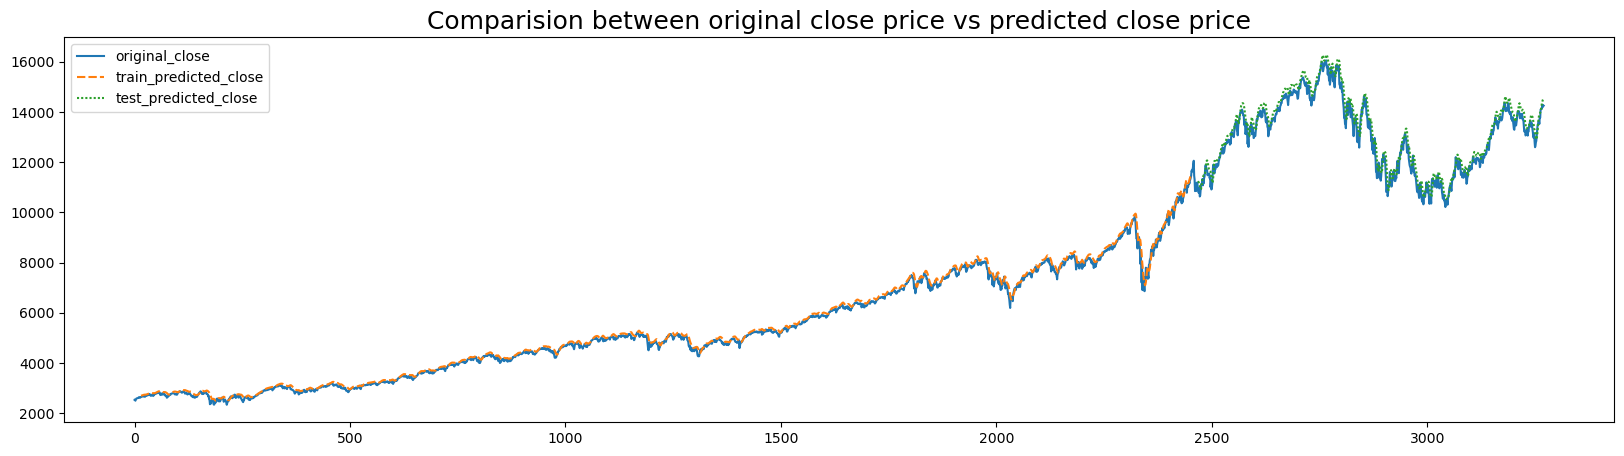

In [30]:
#shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

#shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(), 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)




# Apple Inc. (AAPL)

In [31]:
#Import neccary libraries 
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


1/1 [==============================] - 0s 7ms/step
Output of predicted next days:  10
Output of predicted next days:  [[0.8898371458053589], [0.8954508900642395], [0.9039120078086853], [0.9135602116584778], [0.9237212538719177], [0.9341862201690674], [0.9447052478790283], [0.9553233981132507], [0.9658559560775757], [0.9763661026954651]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


Text(0.5, 1.0, 'Compare last 15 days vs next 10 days')

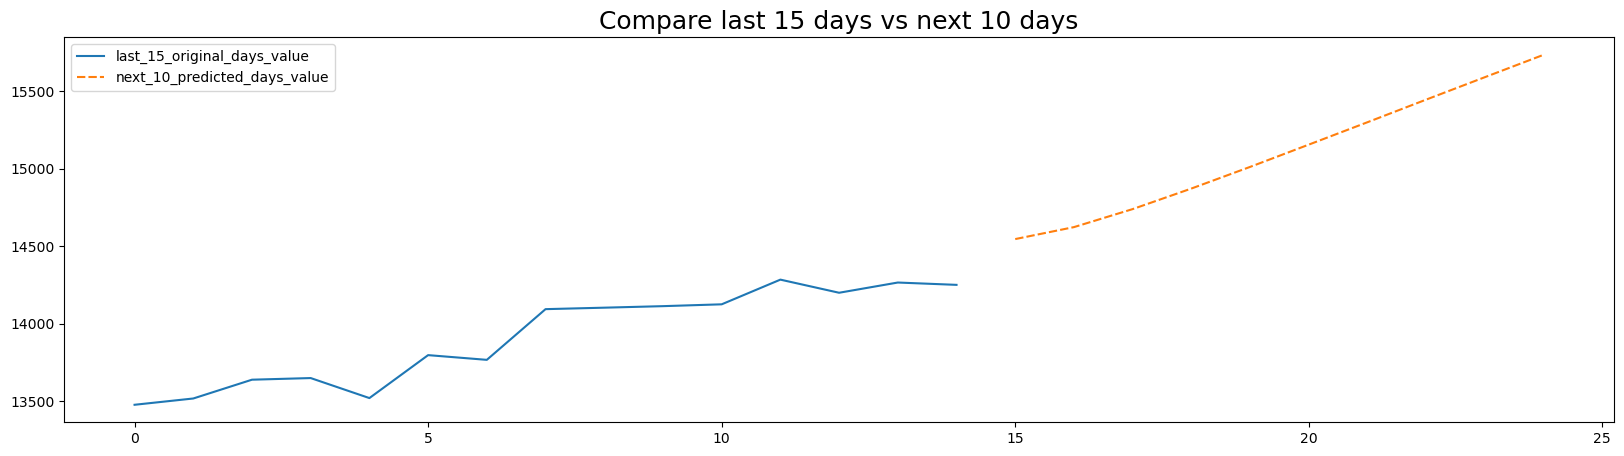

In [32]:
#Create array of last 15 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10

while(i<pred_days): 
  if(len(temp_input)>time_step):
    x_input=np.array(temp_input[1:]) #print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1) 
    yhat = model.predict(np.expand_dims(x_input, 2)) #print("{} day output {}".format(i,yhat)) 
    temp_input.extend(yhat[0]) 
    temp_input=temp_input[1:] 
    
    lst_output.extend(yhat.tolist()) 
    i=i+1 

  else: 
    yhat = model.predict(np.expand_dims(x_input, 2)) 
    temp_input.extend(yhat[0]) 

    lst_output.extend(yhat.tolist()) 
    i=i+1 

print("Output of predicted next days: ", len(lst_output))
print("Output of predicted next days: ",lst_output)

#List of days used for comparision

last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
len(last_original_days_value)

#Empty dataframe for plot
temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

#Save last 15 days plus next 10 days for comparision
last_original_days_value[0:time_step] = scaler.inverse_transform(closep[len(closep)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({'last_15_original_days_value':last_original_days_value, 'next_10_predicted_days_value':next_predicted_days_value})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=new_pred_plot)
plt.title("Compare last 15 days vs next 10 days",fontsize=18)


### **Import the dataset and basic statistics**

In [179]:
# read the CSV file into a DataFrame - 10 Years of data
df = pd.read_csv("AAPL.csv")
df_apple = df

In [34]:
#obtain basic statistics of the dataset
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,76.132140,76.971314,75.347455,76.196240,74.236213,1.394929e+08
std,55.253218,55.903857,54.657563,55.310761,55.787813,8.641443e+07
min,17.684999,17.911785,17.626785,17.849285,15.648316,3.145820e+07
25%,29.400624,29.638125,29.166250,29.405624,26.989092,8.255815e+07
50%,47.447500,47.906250,47.015000,47.528749,45.452425,1.136750e+08
75%,132.580002,134.177494,131.150005,132.412494,131.015095,1.695006e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


### **Data-Preprocessing**

In [35]:
#create a dataframe using lcosing proces for modelling
close_prices = df[['Date','Adj Close']]
close_stock = close_prices.copy()
#transform features using minmax scaler 
del close_prices['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closep=scaler.fit_transform(np.array(close_prices).reshape(-1,1))
print(closep.shape)


(2516, 1)


In [36]:
#create training and testing size
training_size=int(len(closep)*0.75)
test_size=len(closep)-training_size
train_data,test_data=closep[0:training_size,:],closep[training_size:len(closep),:1]


In [37]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3-----99 100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [38]:
#create training and test datasets
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (1871, 15)
y_train:  (1871,)
X_test:  (613, 15)
y_test (613,)


### **K-Nearest Neighbours**

In [39]:
from sklearn.neighbors import KNeighborsRegressor

K = time_step
model = KNeighborsRegressor(n_neighbors=K)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [40]:
#  for KNN
# make predictions on training and test sets using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# reshape the predictions to match the shape of the target variables
train_predictions_reshaped = train_predictions.reshape(-1, 1)
test_predictions_reshaped = test_predictions.reshape(-1, 1)


In [41]:
# Converting to original form
train_predict = scaler.inverse_transform(train_predictions_reshaped)
test_predict = scaler.inverse_transform(test_predictions_reshaped)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [42]:
#calculating measure values for the model
print("KNN- Train RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("KNN- Train MSE: ", mean_squared_error(original_ytrain,train_predict))
print("KNN- Test RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("KNN- Test MSE: ", mean_squared_error(original_ytest,test_predict))
print("KNN- Train R2 score:", r2_score(original_ytrain, train_predict))
print("KNN- Test R2 score:", r2_score(original_ytest, test_predict))

KNN- Train RMSE:  1.5362102743640522
KNN- Train MSE:  2.3599420070616763
KNN- Test RMSE:  31.93440833411873
KNN- Test MSE:  1019.8064356502316
KNN- Train R2 score: 0.9975148362359224
KNN- Test R2 score: -2.725657854165909


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

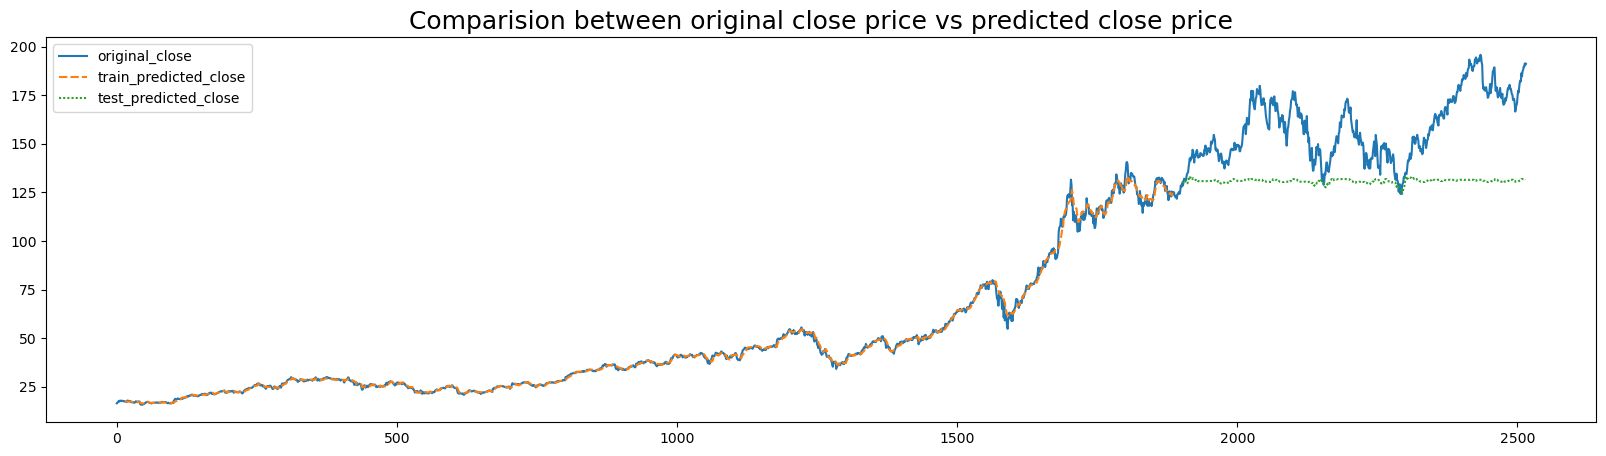

In [43]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

# **GRU**

In [44]:

print("X_train: ", X_train.shape) 
print("X_test: ", X_test.shape)


X_train:  (1871, 15)
X_test:  (613, 15)


In [45]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22401 (87.50 KB)
Trainable params: 22401 (87.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)

Epoch 1/10
375/375 [==============================] - 4s 7ms/step - loss: 6.6376e-04 - val_loss: 0.0019
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 2.9167e-04 - val_loss: 0.0013
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 2.3873e-04 - val_loss: 4.7075e-04
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 1.4594e-04 - val_loss: 4.3863e-04
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 1.3899e-04 - val_loss: 6.9615e-04
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 1.3905e-04 - val_loss: 0.0034
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 1.5539e-04 - val_loss: 4.7078e-04
Epoch 8/10
375/375 [==============================] - 2s 6ms/step - loss: 1.0071e-04 - val_loss: 5.2964e-04
Epoch 9/10
375/375 [==============================] - 2s 6ms/step - loss: 8.5703e-05 - val_loss: 0.0015
Epoch 10/10
375/375 [=======================

In [48]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train) 
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape


20/20 [==============================] - 0s 2ms/step


((1871, 1), (613, 1))

In [49]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict) 
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


In [50]:
# Evaluation metrices RMSE and MAE
print("	")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("	")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("	")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("	")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print("	")



	
Train data RMSE:  1.3090228662919234
Train data MSE:  1.7135408644751227
Test data MAE:  0.8168111378643252
	
Test data RMSE:  3.338888397165807
Test data MSE:  11.148175728728454
Test data MAE:  2.6218748332682824
	
Train data explained variance regression score: 0.9981958078839944
Test data explained variance regression score: 0.9643732774610309
	
Train data R2 score: 0.9981955363089783
Test data R2 score: 0.9592723805112324
	


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

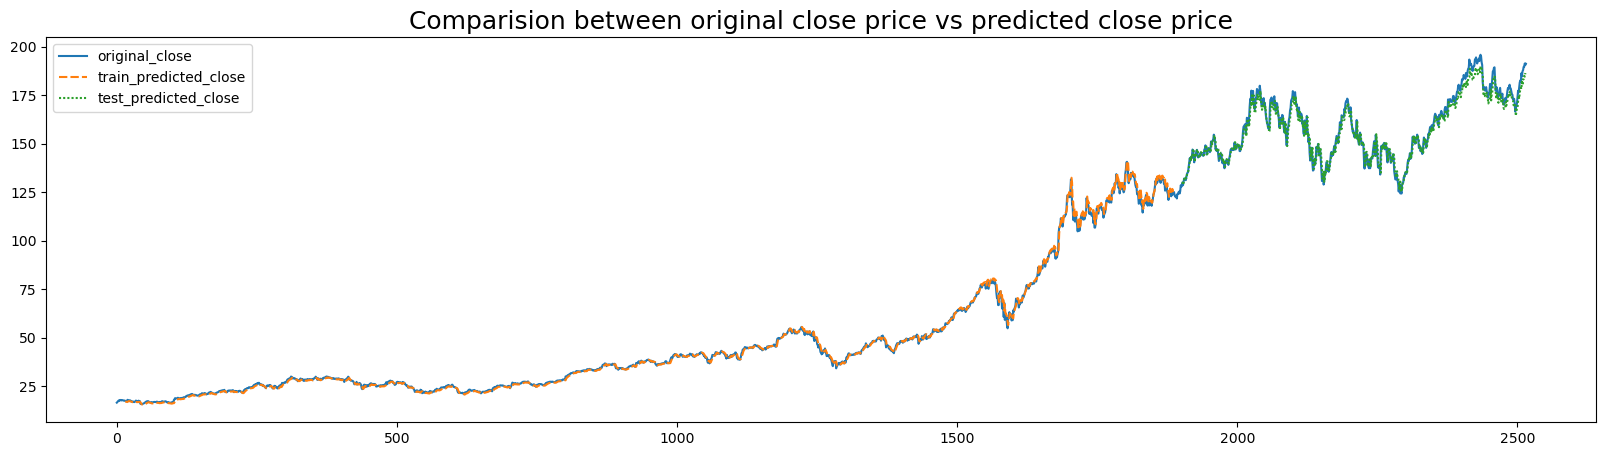

In [51]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **RFR**

In [52]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [53]:
# Lets Do the prediction
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1871, 1)
Test data prediction: (613, 1)


In [54]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [55]:
# Evaluation metrices RMSE and MAE
print("---------------------------------------------------------------------------------------------------------")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


---------------------------------------------------------------------------------------------------------
Train data RMSE:  0.4753407049707401
Train data MSE:  0.22594878580208017
Test data MAE:  0.2578707653180105
---------------------------------------------------------------------------------------------------------
Test data RMSE:  26.626630702201883
Test data MSE:  708.9774625514399
Test data MAE:  21.579046476231657
---------------------------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9997620632794475
Test data explained variance regression score: 0.08774591469102433
---------------------------------------------------------------------------------------------------------
Train data R2 score: 0.9997620620619776
Test data R2 score: -1.5901066706813038


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

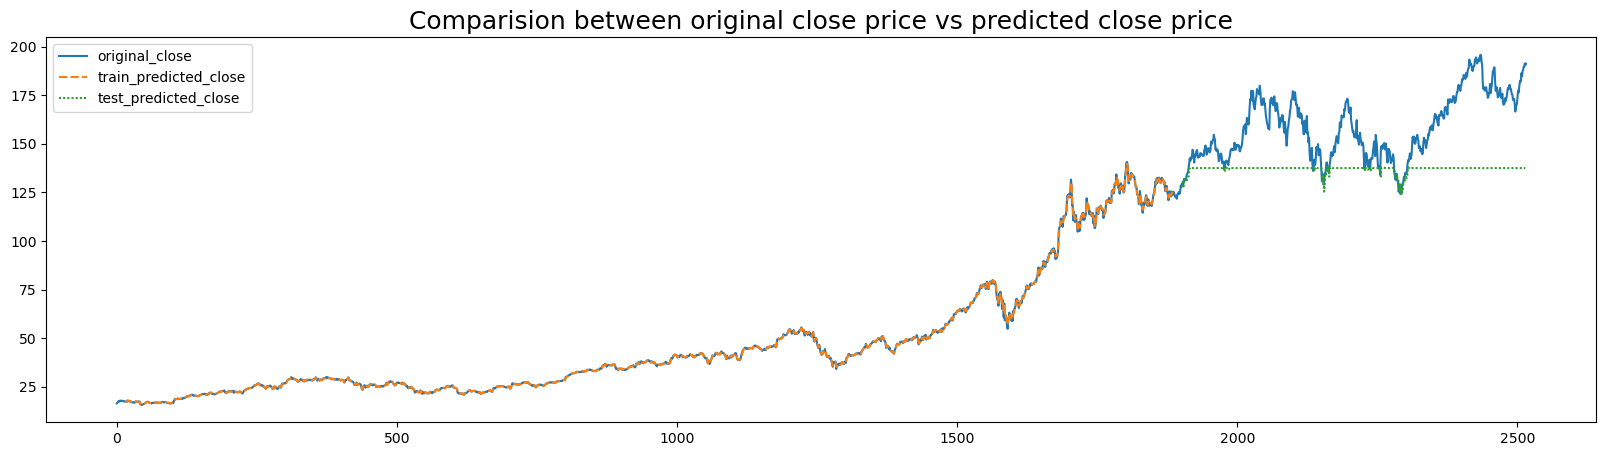

In [56]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **LSTM**

In [57]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler




In [58]:
#reshape (samples, time steps, features)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")



X_train: (1871, 15, 1)
X_test: (613, 15, 1)


In [59]:
#summary

model.summary()

#epoch model fit

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


#Prediction

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0010 - val_loss: 0.0111
Epoch 2/10
375/375 [==============================] 

In [60]:
#Performance metrics
train_predict.shape, test_predict.shape
#Transform the data back to its original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))



In [61]:
# Evaluation metrices RMSE and MAE

print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


Train data RMSE:  2.25176332994315
Train data MSE:  5.070438094076664
Test data MAE:  1.4129368288942843
Test data RMSE:  5.757488316400466
Test data MSE:  33.14867171348787
Test data MAE:  4.561670585696945
Train data explained variance regression score: 0.9946637801499285
Test data explained variance regression score: 0.8934548649862519
Train data R2 score: 0.9946605175120015
Test data R2 score: 0.8788979900428074


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

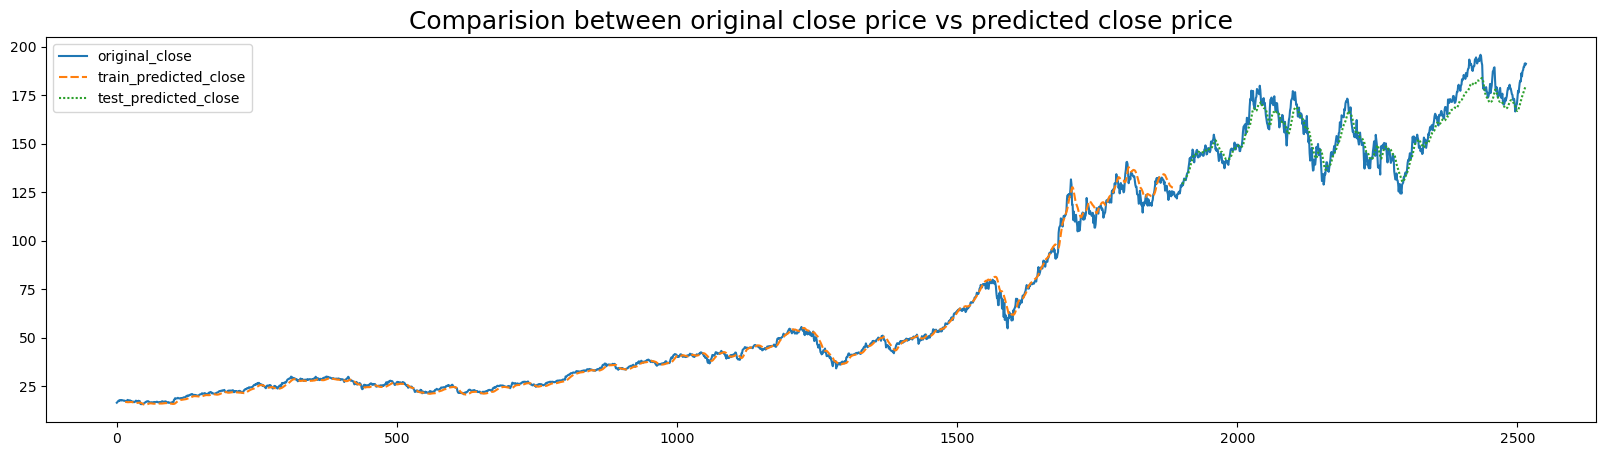

In [62]:
#shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

#shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(), 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)




1/1 [==============================] - 0s 7ms/step
Output of predicted next days:  10
Output of predicted next days:  [[0.9145205616950989], [0.9102083444595337], [0.9031330943107605], [0.8953057527542114], [0.887749433517456], [0.8808810114860535], [0.8747991323471069], [0.8691853880882263], [0.8641856908798218], [0.8594722747802734]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


Text(0.5, 1.0, 'Compare last 15 days vs next 10 days')

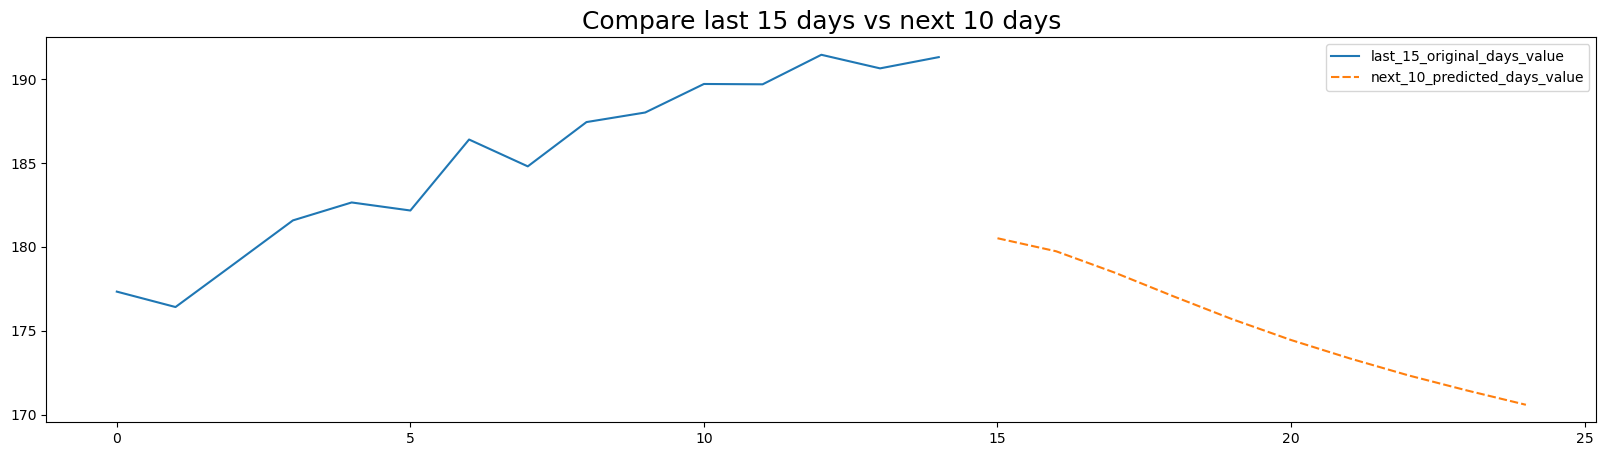

In [63]:
#Create array of last 15 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10

while(i<pred_days): 
  if(len(temp_input)>time_step):
    x_input=np.array(temp_input[1:]) #print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1) 
    yhat = model.predict(np.expand_dims(x_input, 2)) #print("{} day output {}".format(i,yhat)) 
    temp_input.extend(yhat[0]) 
    temp_input=temp_input[1:] 
    
    lst_output.extend(yhat.tolist()) 
    i=i+1 

  else: 
    yhat = model.predict(np.expand_dims(x_input, 2)) 
    temp_input.extend(yhat[0]) 

    lst_output.extend(yhat.tolist()) 
    i=i+1 

print("Output of predicted next days: ", len(lst_output))
print("Output of predicted next days: ",lst_output)

#List of days used for comparision

last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
len(last_original_days_value)

#Empty dataframe for plot
temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

#Save last 15 days plus next 10 days for comparision
last_original_days_value[0:time_step] = scaler.inverse_transform(closep[len(closep)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({'last_15_original_days_value':last_original_days_value, 'next_10_predicted_days_value':next_predicted_days_value})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=new_pred_plot)
plt.title("Compare last 15 days vs next 10 days",fontsize=18)


# NYSE Composite

Import the dataset and basic statistics

In [80]:
#Import neccary libraries 
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


In [213]:
# read the CSV file into a DataFrame - 1965 - 2023 
df = pd.read_csv("NYA.csv")
df_NYSE = df

In [82]:
#obtain basic statistics of the dataset
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5033.000000,5033.000000,5033.000000,5033.000000,5033.000000,5.033000e+03
mean,10334.859882,10391.308189,10272.751169,10335.642568,10335.642568,3.715386e+09
std,3062.634405,3073.226909,3051.604519,3062.430574,3062.430574,1.328813e+09
min,4226.310059,4321.759766,4181.750000,4226.310059,4226.310059,0.000000e+00
25%,7825.009766,7865.410156,7777.270020,7831.979980,7831.979980,3.020770e+09
50%,9974.780273,10033.379883,9911.330078,9978.639648,9978.639648,3.657840e+09
75%,12567.679688,12624.750000,12486.059570,12561.320313,12561.320313,4.316260e+09
max,17353.759766,17442.539063,17285.550781,17353.759766,17353.759766,1.145623e+10


In [83]:
#create a dataframe using lcosing proces for modelling
close_prices = df[['Date','Adj Close']]
close_stock = close_prices.copy()
#transform features using minmax scaler 
del close_prices['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closep=scaler.fit_transform(np.array(close_prices).reshape(-1,1))
print(closep.shape)

(5033, 1)


In [84]:
#create training and testing size
training_size=int(len(closep)*0.75)
test_size=len(closep)-training_size
train_data,test_data=closep[0:training_size,:],closep[training_size:len(closep),:1]


In [85]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3-----99 100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [86]:
#create training and test datasets
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (3758, 15)
y_train:  (3758,)
X_test:  (1243, 15)
y_test (1243,)


### **K-Nearest Neighbours**

In [87]:
from sklearn.neighbors import KNeighborsRegressor

K = time_step
model = KNeighborsRegressor(n_neighbors=K)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [88]:
#  for KNN
# make predictions on training and test sets using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# reshape the predictions to match the shape of the target variables
train_predictions_reshaped = train_predictions.reshape(-1, 1)
test_predictions_reshaped = test_predictions.reshape(-1, 1)


In [89]:
# Converting to original form
train_predict = scaler.inverse_transform(train_predictions_reshaped)
test_predict = scaler.inverse_transform(test_predictions_reshaped)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [90]:
#calculating measure values for the model
print("KNN- Train RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("KNN- Train MSE: ", mean_squared_error(original_ytrain,train_predict))
print("KNN- Test RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("KNN- Test MSE: ", mean_squared_error(original_ytest,test_predict))
print("KNN- Train R2 score:", r2_score(original_ytrain, train_predict))
print("KNN- Test R2 score:", r2_score(original_ytest, test_predict))

KNN- Train RMSE:  112.42784982457482
KNN- Train MSE:  12640.021416177147
KNN- Test RMSE:  2150.3177642400024
KNN- Test MSE:  4623866.487206122
KNN- Train R2 score: 0.9966950263869723
KNN- Test R2 score: -0.520134580967526


Train predicted data:  (5033, 1)
Test predicted data:  (5033, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

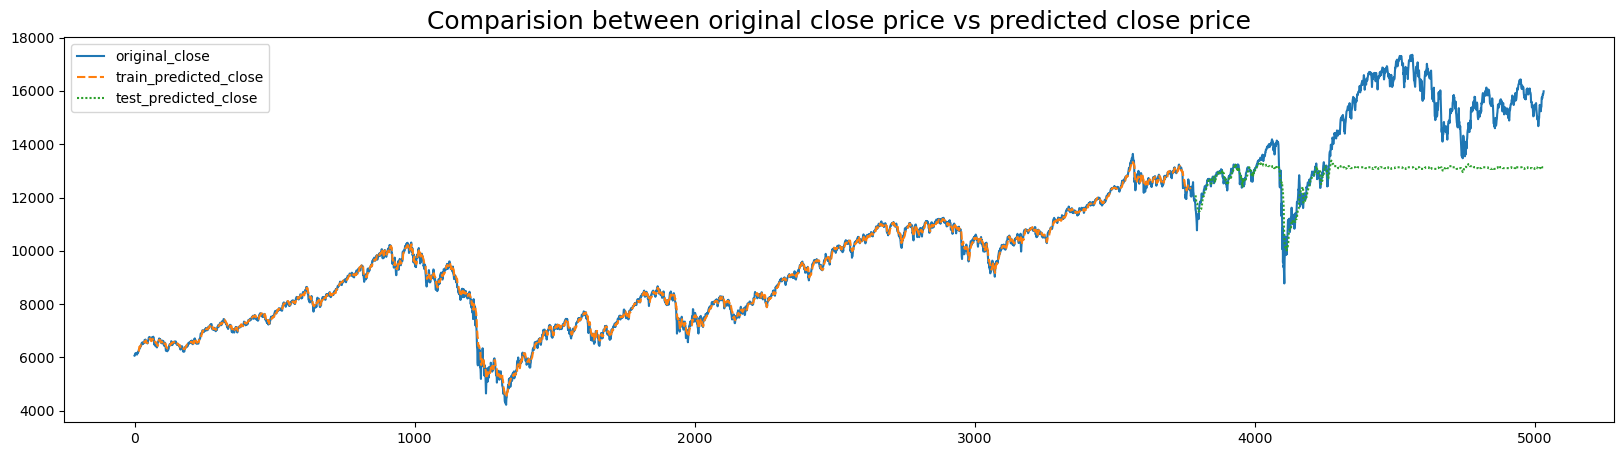

In [92]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

# **GRU**

In [93]:

print("X_train: ", X_train.shape) 
print("X_test: ", X_test.shape)


X_train:  (3758, 15)
X_test:  (1243, 15)


In [94]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22401 (87.50 KB)
Trainable params: 22401 (87.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)

Epoch 1/10
752/752 [==============================] - 6s 7ms/step - loss: 0.0014 - val_loss: 8.3056e-04
Epoch 2/10
752/752 [==============================] - 4s 6ms/step - loss: 1.9681e-04 - val_loss: 3.8881e-04
Epoch 3/10
752/752 [==============================] - 4s 6ms/step - loss: 1.6882e-04 - val_loss: 8.2037e-04
Epoch 4/10
752/752 [==============================] - 5s 6ms/step - loss: 1.3402e-04 - val_loss: 2.6313e-04
Epoch 5/10
752/752 [==============================] - 5s 6ms/step - loss: 1.0292e-04 - val_loss: 1.9743e-04
Epoch 6/10
752/752 [==============================] - 5s 6ms/step - loss: 1.0051e-04 - val_loss: 3.0327e-04
Epoch 7/10
752/752 [==============================] - 5s 6ms/step - loss: 9.6485e-05 - val_loss: 4.9525e-04
Epoch 8/10
752/752 [==============================] - 5s 6ms/step - loss: 1.0542e-04 - val_loss: 2.5514e-04
Epoch 9/10
752/752 [==============================] - 4s 6ms/step - loss: 9.9287e-05 - val_loss: 7.0691e-04
Epoch 10/10
752/752 [===========

In [97]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train) 
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

39/39 [==============================] - 0s 2ms/step


((3758, 1), (1243, 1))

In [98]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict) 
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


In [99]:
# Evaluation metrices RMSE and MAE
print("	")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("	")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("	")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("	")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print("	")



	
Train data RMSE:  105.65808763466464
Train data MSE:  11163.631482614473
Test data MAE:  79.23928691452403
	
Test data RMSE:  182.3412402654341
Test data MSE:  33248.327901536766
Test data MAE:  130.74565535428403
	
Train data explained variance regression score: 0.9971028357942489
Test data explained variance regression score: 0.9896932188805802
	
Train data R2 score: 0.9970810565693832
Test data R2 score: 0.9890693355566561
	


Train predicted data:  (5033, 1)
Test predicted data:  (5033, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

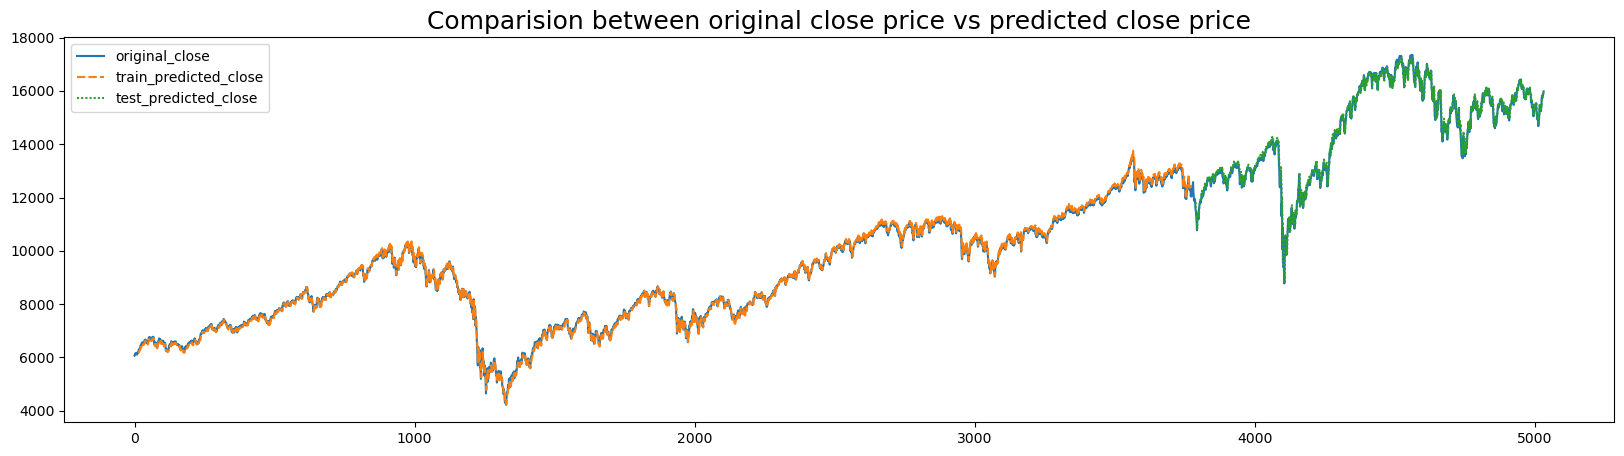

In [100]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

# **RFR**

In [101]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [102]:
# Lets Do the prediction
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (3758, 1)
Test data prediction: (1243, 1)


In [103]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [104]:
# Evaluation metrices RMSE and MAE
print("---------------------------------------------------------------------------------------------------------")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


---------------------------------------------------------------------------------------------------------
Train data RMSE:  37.107620776852414
Train data MSE:  1376.975519718689
Test data MAE:  25.675428951961194
---------------------------------------------------------------------------------------------------------
Test data RMSE:  1896.7121328104774
Test data MSE:  3597516.91475047
Test data MAE:  1448.737505395164
---------------------------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9996400334536981
Test data explained variance regression score: 0.4705977589298159
---------------------------------------------------------------------------------------------------------
Train data R2 score: 0.9996399636038091
Test data R2 score: -0.18271361918846196


Train predicted data:  (5033, 1)
Test predicted data:  (5033, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

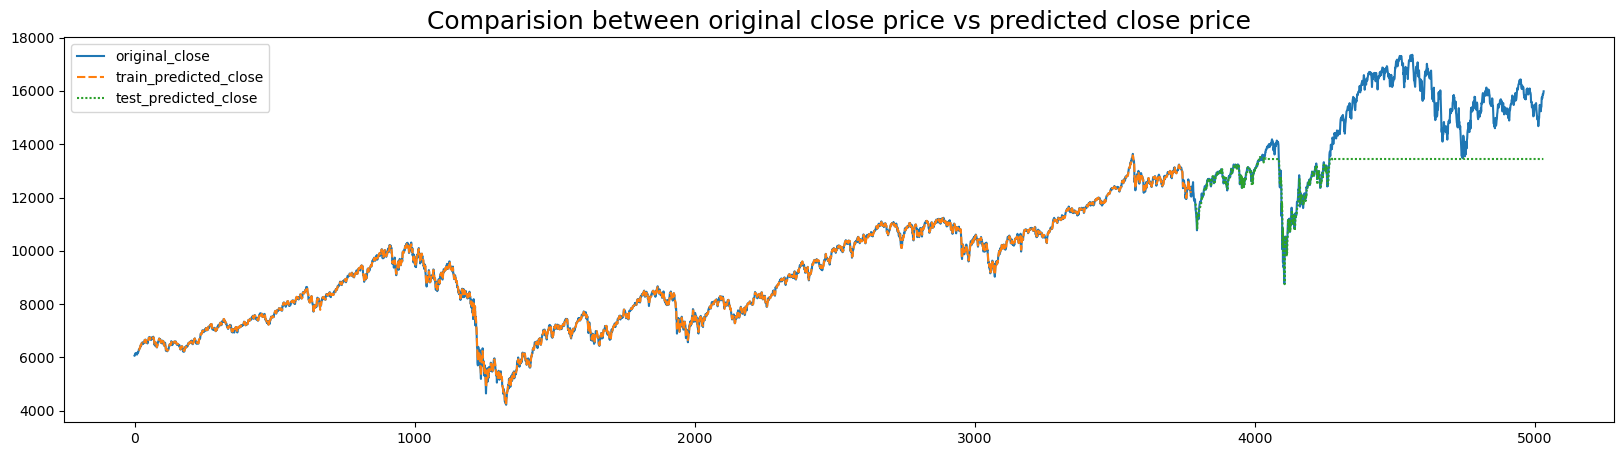

In [105]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **LSTM**

In [106]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


In [107]:
#reshape (samples, time steps, features)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")



X_train: (3758, 15, 1)
X_test: (1243, 15, 1)


In [108]:
#summary

model.summary()

#epoch model fit

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


#Prediction

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
752/752 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 2/10
752/752 [==============================] 

In [109]:
#Performance metrics
train_predict.shape, test_predict.shape
#Transform the data back to its original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [110]:
# Evaluation metrices RMSE and MAE

print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


Train data RMSE:  107.04658500526695
Train data MSE:  11458.971361289841
Test data MAE:  81.19714609904705
Test data RMSE:  194.6769324580712
Test data MSE:  37899.10803128442
Test data MAE:  146.75609902800684
Train data explained variance regression score: 0.9973374873103542
Test data explained variance regression score: 0.9895703051999114
Train data R2 score: 0.997003834350072
Test data R2 score: 0.9875403528917657


Train predicted data:  (5033, 1)
Test predicted data:  (5033, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

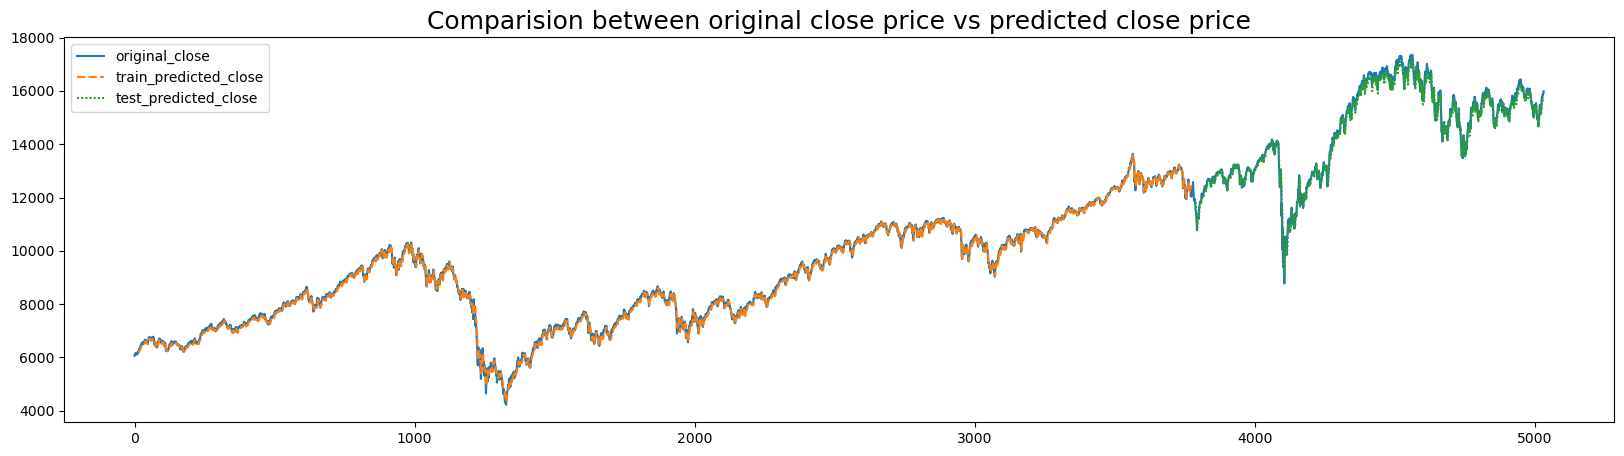

In [111]:
#shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

#shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(), 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)


# **Alphabet Inc. (GOOG)**

In [112]:
#Import neccary libraries 
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


### **Import the dataset and basic statistics**

In [113]:
# read the CSV file into a DataFrame
df = pd.read_csv("GOOG.csv")

In [114]:
#obtain basic statistics of the dataset
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,67.909730,68.634929,67.230408,67.948713,67.948713,3.419414e+07
std,36.873897,37.329954,36.470633,36.901595,36.901595,1.910753e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,1.584340e+05
25%,37.150751,37.361624,36.849998,37.135251,37.135251,2.304412e+07
50%,56.271000,56.878000,55.652500,56.227001,56.227001,2.908500e+07
75%,97.762502,99.483503,96.574997,97.974998,97.974998,3.864485e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,2.234866e+08


### **Data-Preprocessing**

In [115]:
#create a dataframe using lcosing proces for modelling
close_prices = df[['Date','Adj Close']]
close_stock = close_prices.copy()
#transform features using minmax scaler 
del close_prices['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closep=scaler.fit_transform(np.array(close_prices).reshape(-1,1))
print(closep.shape)


(2516, 1)


In [116]:
#create training and testing size
training_size=int(len(closep)*0.75)
test_size=len(closep)-training_size
train_data,test_data=closep[0:training_size,:],closep[training_size:len(closep),:1]


In [117]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3-----99 100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [118]:
#create training and test datasets
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (1871, 15)
y_train:  (1871,)
X_test:  (613, 15)
y_test (613,)


### **K-Nearest Neighbours**

In [119]:
from sklearn.neighbors import KNeighborsRegressor

K = time_step
model = KNeighborsRegressor(n_neighbors=K)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [120]:
#  for KNN
# make predictions on training and test sets using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# reshape the predictions to match the shape of the target variables
train_predictions_reshaped = train_predictions.reshape(-1, 1)
test_predictions_reshaped = test_predictions.reshape(-1, 1)


In [121]:
# Converting to original form
train_predict = scaler.inverse_transform(train_predictions_reshaped)
test_predict = scaler.inverse_transform(test_predictions_reshaped)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [122]:
#calculating measure values for the model
print("KNN- Train RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("KNN- Train MSE: ", mean_squared_error(original_ytrain,train_predict))
print("KNN- Test RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("KNN- Test MSE: ", mean_squared_error(original_ytest,test_predict))
print("KNN- Train R2 score:", r2_score(original_ytrain, train_predict))
print("KNN- Test R2 score:", r2_score(original_ytest, test_predict))

KNN- Train RMSE:  1.2391532553437596
KNN- Train MSE:  1.5355007902290367
KNN- Test RMSE:  15.508702157779975
KNN- Test MSE:  240.51984261872926
KNN- Train R2 score: 0.9963825750115093
KNN- Test R2 score: 0.22086615809882826


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

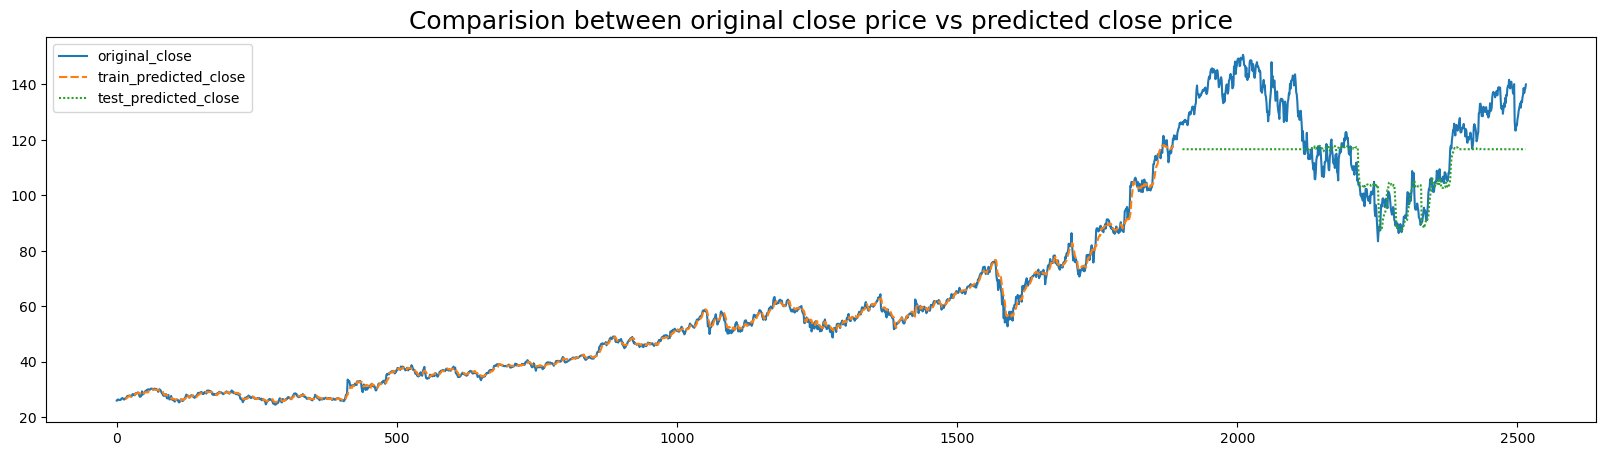

In [123]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

# **GRU**

In [124]:

print("X_train: ", X_train.shape) 
print("X_test: ", X_test.shape)


X_train:  (1871, 15)
X_test:  (613, 15)


In [125]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [126]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22401 (87.50 KB)
Trainable params: 22401 (87.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [127]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)

Epoch 1/10
375/375 [==============================] - 4s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 2.6826e-04 - val_loss: 0.0012
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 1.7924e-04 - val_loss: 9.0757e-04
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 1.4673e-04 - val_loss: 0.0015
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 1.7584e-04 - val_loss: 4.6496e-04
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 1.2104e-04 - val_loss: 0.0023
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 1.3240e-04 - val_loss: 4.1275e-04
Epoch 8/10
375/375 [==============================] - 2s 6ms/step - loss: 1.1890e-04 - val_loss: 5.9752e-04
Epoch 9/10
375/375 [==============================] - 2s 6ms/step - loss: 1.0040e-04 - val_loss: 4.6935e-04
Epoch 10/10
375/375 [===========================

In [128]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train) 
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape


20/20 [==============================] - 0s 2ms/step


((1871, 1), (613, 1))

In [129]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict) 
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


In [130]:
# Evaluation metrices RMSE and MAE
print("	")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("	")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("	")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("	")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print("	")



	
Train data RMSE:  1.3476147826815308
Train data MSE:  1.8160656025017896
Test data MAE:  0.9614225999367014
	
Test data RMSE:  3.8699956120735233
Test data MSE:  14.976866037468325
Test data MAE:  3.219168251952332
	
Train data explained variance regression score: 0.9957216072102821
Test data explained variance regression score: 0.9797184395050615
	
Train data R2 score: 0.9957216035751772
Test data R2 score: 0.9514843222564823
	


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

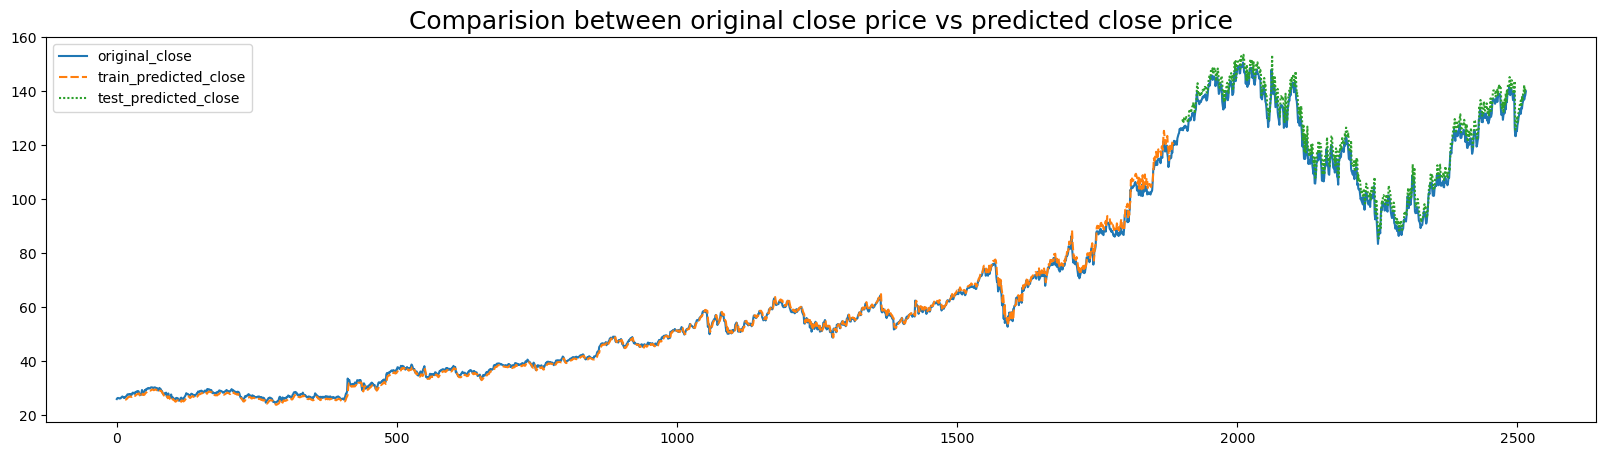

In [131]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **RFR**

In [132]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [133]:
# Lets Do the prediction
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1871, 1)
Test data prediction: (613, 1)


In [134]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [135]:
# Evaluation metrices RMSE and MAE
print("---------------------------------------------------------------------------------------------------------")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


---------------------------------------------------------------------------------------------------------
Train data RMSE:  0.39389297844588694
Train data MSE:  0.15515167846897196
Test data MAE:  0.24365677253340529
---------------------------------------------------------------------------------------------------------
Test data RMSE:  14.67103289218628
Test data MSE:  215.23920612361175
Test data MAE:  11.368147245954331
---------------------------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9996345572134738
Test data explained variance regression score: 0.5637464800267683
---------------------------------------------------------------------------------------------------------
Train data R2 score: 0.9996344843569789
Test data R2 score: 0.3027596069872489


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

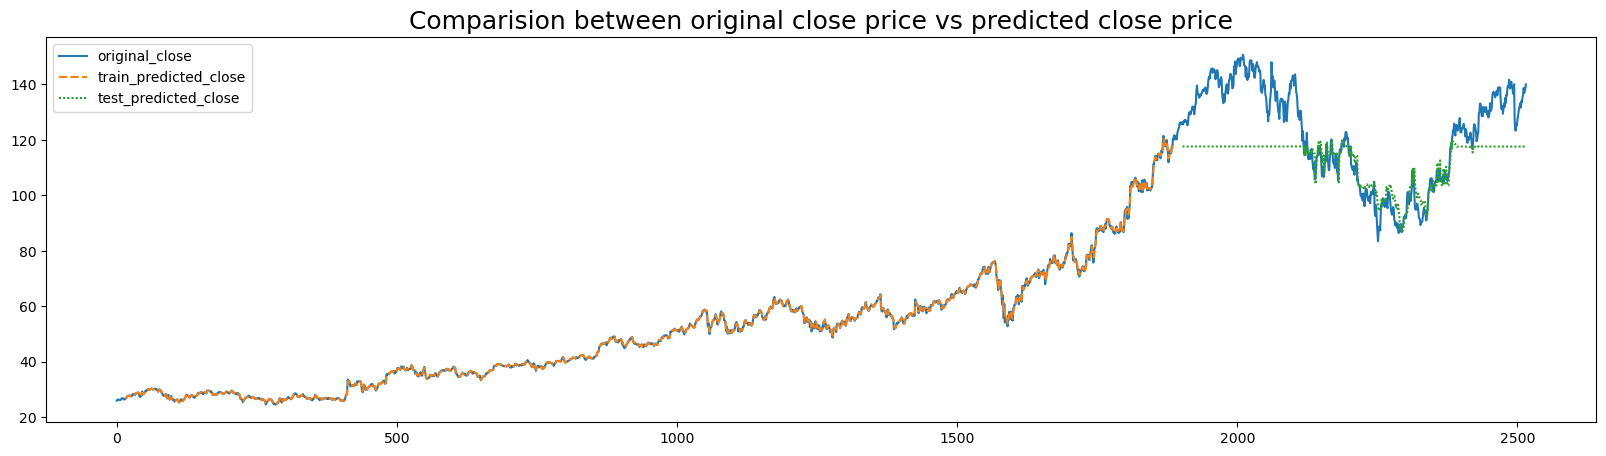

In [136]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **LSTM**

In [137]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler




In [138]:
#reshape (samples, time steps, features)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")



X_train: (1871, 15, 1)
X_test: (613, 15, 1)


In [139]:
#summary

model.summary()

#epoch model fit

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


#Prediction

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 3s 5ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 2/10
375/375 [==============================] 

In [140]:
#Performance metrics
train_predict.shape, test_predict.shape
#Transform the data back to its original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))



In [141]:
# Evaluation metrices RMSE and MAE

print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


Train data RMSE:  1.8712055232336278
Train data MSE:  3.5014101101800343
Test data MAE:  1.5045547945360906
Test data RMSE:  4.268170588268609
Test data MSE:  18.217280170561207
Test data MAE:  3.5420394222868112
Train data explained variance regression score: 0.9950813189753458
Test data explained variance regression score: 0.9585309652514147
Train data R2 score: 0.9917511677570482
Test data R2 score: 0.940987407385015


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

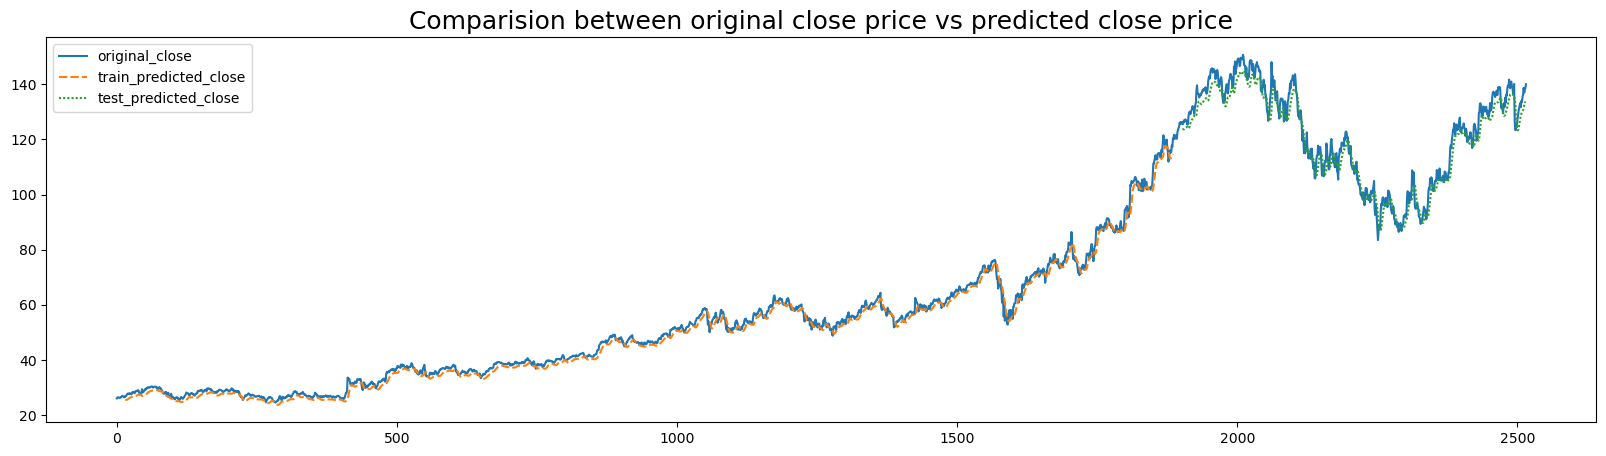

In [142]:
#shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

#shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(), 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)




1/1 [==============================] - 0s 8ms/step
Output of predicted next days:  10
Output of predicted next days:  [[0.874792218208313], [0.8724225759506226], [0.8661505579948425], [0.8582447171211243], [0.8499404191970825], [0.8418074250221252], [0.8342041969299316], [0.8269538879394531], [0.8201972246170044], [0.8137480020523071]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


Text(0.5, 1.0, 'Compare last 15 days vs next 10 days')

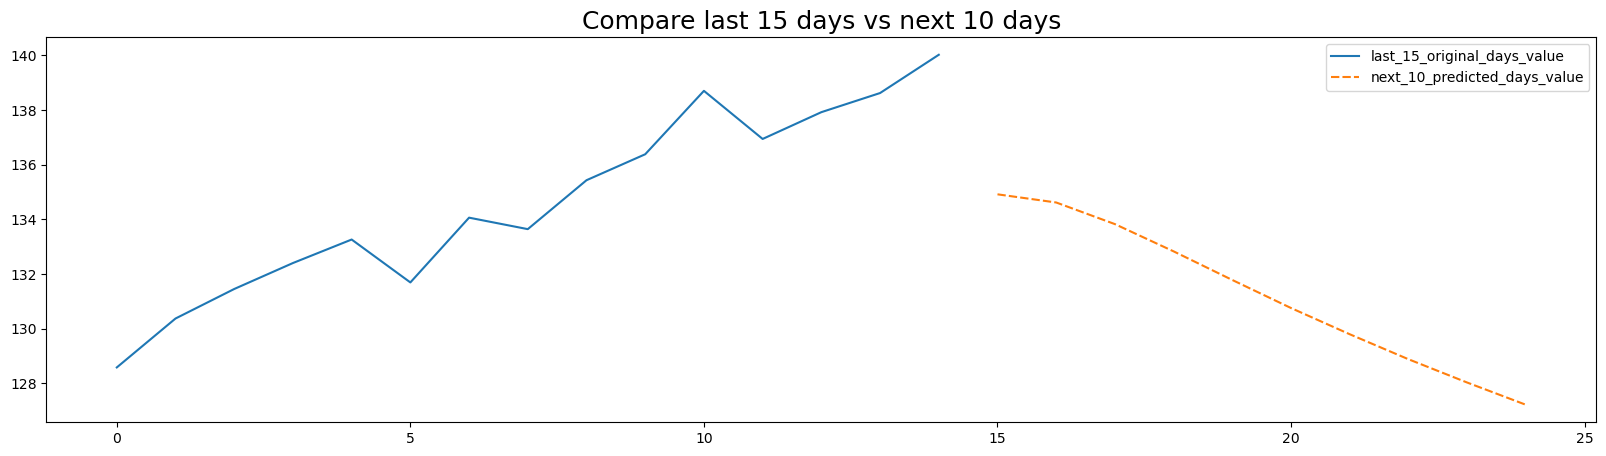

In [143]:
#Create array of last 15 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10

while(i<pred_days): 
  if(len(temp_input)>time_step):
    x_input=np.array(temp_input[1:]) #print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1) 
    yhat = model.predict(np.expand_dims(x_input, 2)) #print("{} day output {}".format(i,yhat)) 
    temp_input.extend(yhat[0]) 
    temp_input=temp_input[1:] 
    
    lst_output.extend(yhat.tolist()) 
    i=i+1 

  else: 
    yhat = model.predict(np.expand_dims(x_input, 2)) 
    temp_input.extend(yhat[0]) 

    lst_output.extend(yhat.tolist()) 
    i=i+1 

print("Output of predicted next days: ", len(lst_output))
print("Output of predicted next days: ",lst_output)

#List of days used for comparision

last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
len(last_original_days_value)

#Empty dataframe for plot
temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

#Save last 15 days plus next 10 days for comparision
last_original_days_value[0:time_step] = scaler.inverse_transform(closep[len(closep)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({'last_15_original_days_value':last_original_days_value, 'next_10_predicted_days_value':next_predicted_days_value})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=new_pred_plot)
plt.title("Compare last 15 days vs next 10 days",fontsize=18)


Continuation with google data

In [144]:
#Import neccary libraries 
!pip install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


### **Import the dataset and basic statistics**

In [177]:
# read the CSV file into a DataFrame
df = pd.read_csv("GOOG.csv")
df_goog = df

In [146]:
#obtain basic statistics of the dataset
df.describe()


,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,67.909730,68.634929,67.230408,67.948713,67.948713,3.419414e+07
std,36.873897,37.329954,36.470633,36.901595,36.901595,1.910753e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,1.584340e+05
25%,37.150751,37.361624,36.849998,37.135251,37.135251,2.304412e+07
50%,56.271000,56.878000,55.652500,56.227001,56.227001,2.908500e+07
75%,97.762502,99.483503,96.574997,97.974998,97.974998,3.864485e+07
max,151.863495,152.100006,149.887497,150.709000,150.709000,2.234866e+08


### **Data-Preprocessing**

In [147]:
#create a dataframe using lcosing proces for modelling
close_prices = df[['Date','Adj Close']]
close_stock = close_prices.copy()
#transform features using minmax scaler 
del close_prices['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closep=scaler.fit_transform(np.array(close_prices).reshape(-1,1))
print(closep.shape)


(2516, 1)


In [148]:
#create training and testing size
training_size=int(len(closep)*0.75)
test_size=len(closep)-training_size
train_data,test_data=closep[0:training_size,:],closep[training_size:len(closep),:1]


In [149]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0] ###i=0, 0,1,2,3-----99 100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [150]:
#create training and test datasets
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (1871, 15)
y_train:  (1871,)
X_test:  (613, 15)
y_test (613,)


### **K-Nearest Neighbours**

In [151]:
from sklearn.neighbors import KNeighborsRegressor

K = time_step
model = KNeighborsRegressor(n_neighbors=K)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [152]:
#  for KNN
# make predictions on training and test sets using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# reshape the predictions to match the shape of the target variables
train_predictions_reshaped = train_predictions.reshape(-1, 1)
test_predictions_reshaped = test_predictions.reshape(-1, 1)


In [153]:
# Converting to original form
train_predict = scaler.inverse_transform(train_predictions_reshaped)
test_predict = scaler.inverse_transform(test_predictions_reshaped)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [154]:
#calculating measure values for the model
print("KNN- Train RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("KNN- Train MSE: ", mean_squared_error(original_ytrain,train_predict))
print("KNN- Test RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("KNN- Test MSE: ", mean_squared_error(original_ytest,test_predict))
print("KNN- Train R2 score:", r2_score(original_ytrain, train_predict))
print("KNN- Test R2 score:", r2_score(original_ytest, test_predict))

KNN- Train RMSE:  1.2391532553437596
KNN- Train MSE:  1.5355007902290367
KNN- Test RMSE:  15.508702157779975
KNN- Test MSE:  240.51984261872926
KNN- Train R2 score: 0.9963825750115093
KNN- Test R2 score: 0.22086615809882826


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

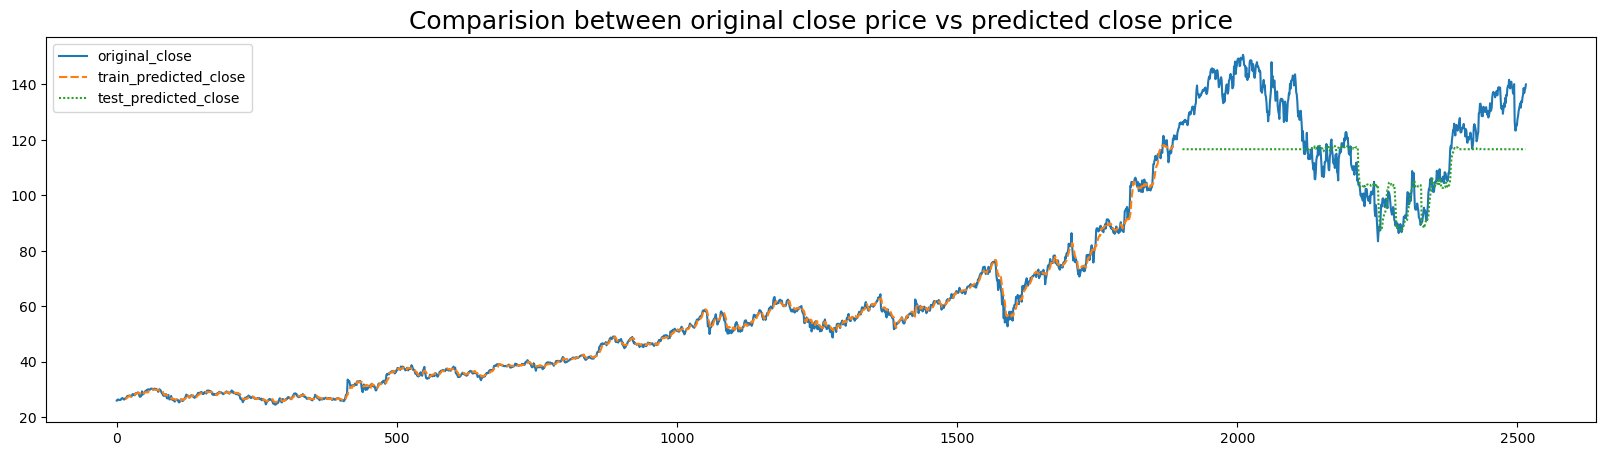

In [155]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

# **GRU**

In [156]:

print("X_train: ", X_train.shape) 
print("X_test: ", X_test.shape)


X_train:  (1871, 15)
X_test:  (613, 15)


In [157]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [158]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22401 (87.50 KB)
Trainable params: 22401 (87.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)

Epoch 1/10
375/375 [==============================] - 4s 7ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 2.9022e-04 - val_loss: 0.0011
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 2.1025e-04 - val_loss: 6.8281e-04
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 2.3707e-04 - val_loss: 6.3528e-04
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 1.6518e-04 - val_loss: 4.5857e-04
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 1.2897e-04 - val_loss: 4.1938e-04
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 1.4157e-04 - val_loss: 4.0896e-04
Epoch 8/10
375/375 [==============================] - 2s 6ms/step - loss: 1.1842e-04 - val_loss: 0.0017
Epoch 9/10
375/375 [==============================] - 2s 6ms/step - loss: 1.2187e-04 - val_loss: 4.0251e-04
Epoch 10/10
375/375 [=======================

In [160]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train) 
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape


20/20 [==============================] - 0s 2ms/step


((1871, 1), (613, 1))

In [161]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict) 
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))


In [162]:
# Evaluation metrices RMSE and MAE
print("	")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("	")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("	")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("	")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))
print("	")



	
Train data RMSE:  1.172071302386834
Train data MSE:  1.3737511378787695
Test data MAE:  0.7668508682199763
	
Test data RMSE:  2.743761338405305
Test data MSE:  7.528226282127671
Test data MAE:  2.0872861173213217
	
Train data explained variance regression score: 0.9973954037917739
Test data explained variance regression score: 0.9800734811850833
	
Train data R2 score: 0.9967636345576943
Test data R2 score: 0.9756132558460324
	


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

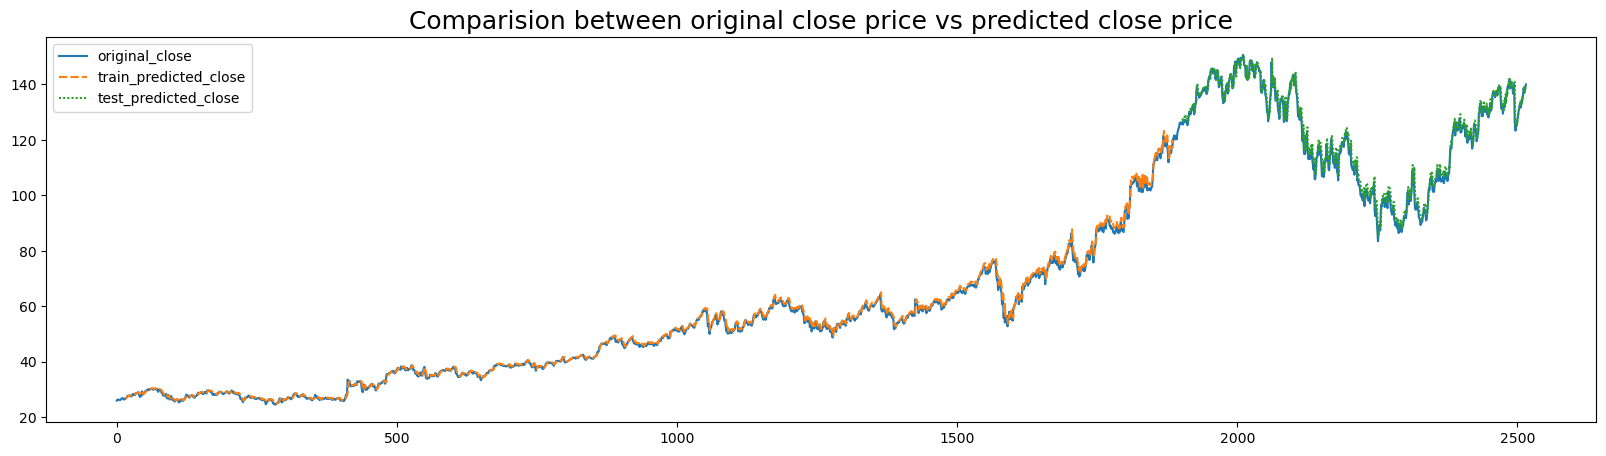

In [163]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **RFR**

In [164]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [165]:
# Lets Do the prediction
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)
print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1871, 1)
Test data prediction: (613, 1)


In [166]:
# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [167]:
# Evaluation metrices RMSE and MAE
print("---------------------------------------------------------------------------------------------------------")
print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))
print("---------------------------------------------------------------------------------------------------------")
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


---------------------------------------------------------------------------------------------------------
Train data RMSE:  0.39389297844588694
Train data MSE:  0.15515167846897196
Test data MAE:  0.24365677253340529
---------------------------------------------------------------------------------------------------------
Test data RMSE:  14.67103289218628
Test data MSE:  215.23920612361175
Test data MAE:  11.368147245954331
---------------------------------------------------------------------------------------------------------
Train data explained variance regression score: 0.9996345572134738
Test data explained variance regression score: 0.5637464800267683
---------------------------------------------------------------------------------------------------------
Train data R2 score: 0.9996344843569789
Test data R2 score: 0.3027596069872489


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

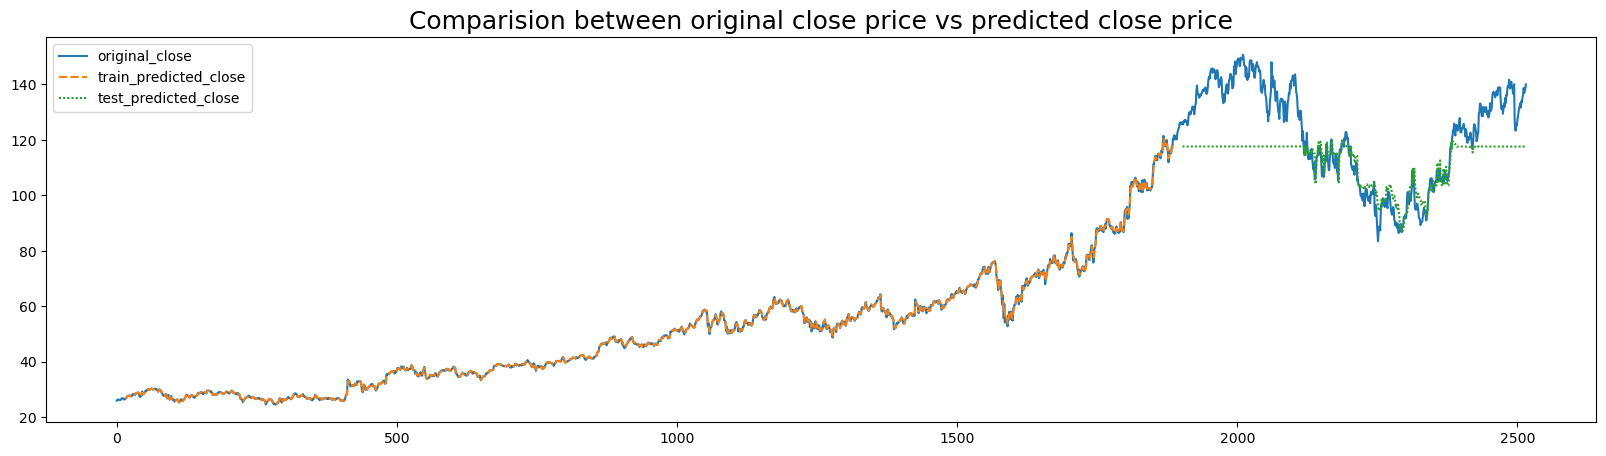

In [168]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)
# shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)
plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)

### **LSTM**

In [169]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler




In [170]:
#reshape (samples, time steps, features)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")



X_train: (1871, 15, 1)
X_test: (613, 15, 1)


In [171]:
#summary

model.summary()

#epoch model fit

model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=5,verbose=1)


#Prediction

train_predict=model.predict(X_train)
test_predict=model.predict(X_test)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
375/375 [==============================] - 4s 6ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 2/10
375/375 [==============================] 

In [172]:
#Performance metrics
train_predict.shape, test_predict.shape
#Transform the data back to its original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))



In [173]:
# Evaluation metrices RMSE and MAE

print("Train data RMSE: ", np.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))

print("Test data RMSE: ", np.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))


Train data RMSE:  1.944094669896505
Train data MSE:  3.77950408552
Test data MAE:  1.6624590635129028
Test data RMSE:  3.3414732327320023
Test data MSE:  11.165443365064457
Test data MAE:  2.7019546256396234
Train data explained variance regression score: 0.9957107844057705
Test data explained variance regression score: 0.9671689180377845
Train data R2 score: 0.9910960172667684
Test data R2 score: 0.9638309476223015


Train predicted data:  (2516, 1)
Test predicted data:  (2516, 1)


Text(0.5, 1.0, 'Comparision between original close price vs predicted close price')

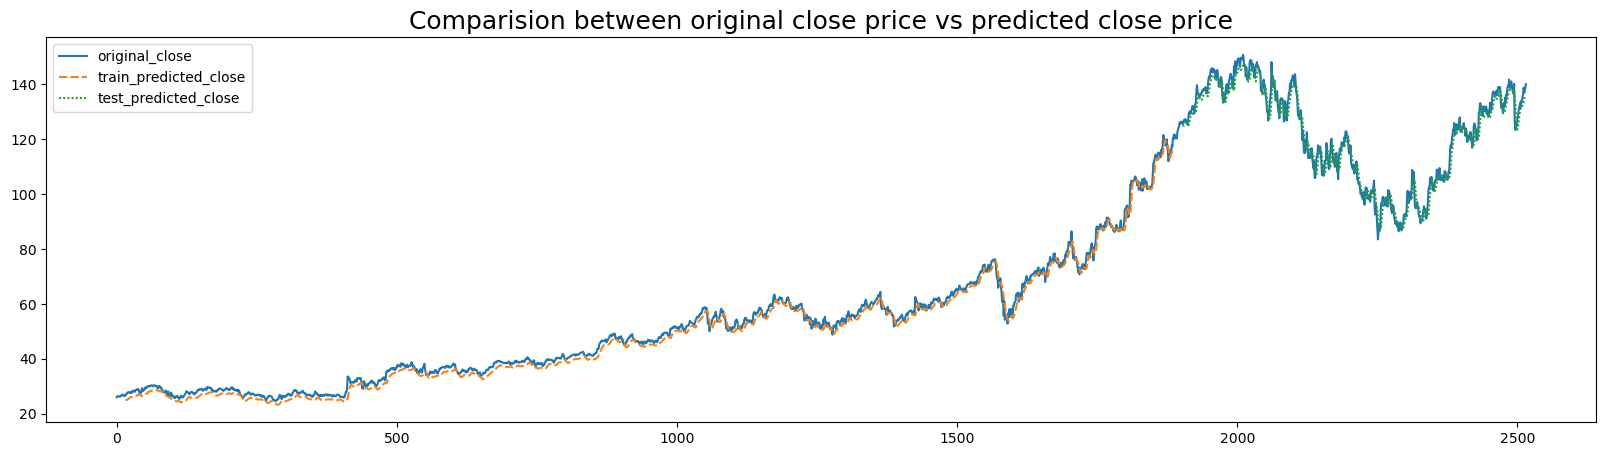

In [174]:
#shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closep)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

#shift test predictions for plotting
testPredictPlot = np.empty_like(closep)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closep)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

plotdf = pd.DataFrame({'Date': close_stock['Date'],'original_close': close_stock['Adj Close'],'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(), 'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=plotdf)
plt.title("Comparision between original close price vs predicted close price",fontsize=18)




1/1 [==============================] - 0s 8ms/step
Output of predicted next days:  10
Output of predicted next days:  [[0.8919026255607605], [0.8902685642242432], [0.8850997090339661], [0.8787711262702942], [0.8723096251487732], [0.866126298904419], [0.8606195449829102], [0.8554902672767639], [0.8510189056396484], [0.8469462990760803]]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


Text(0.5, 1.0, 'Compare last 15 days vs next 10 days')

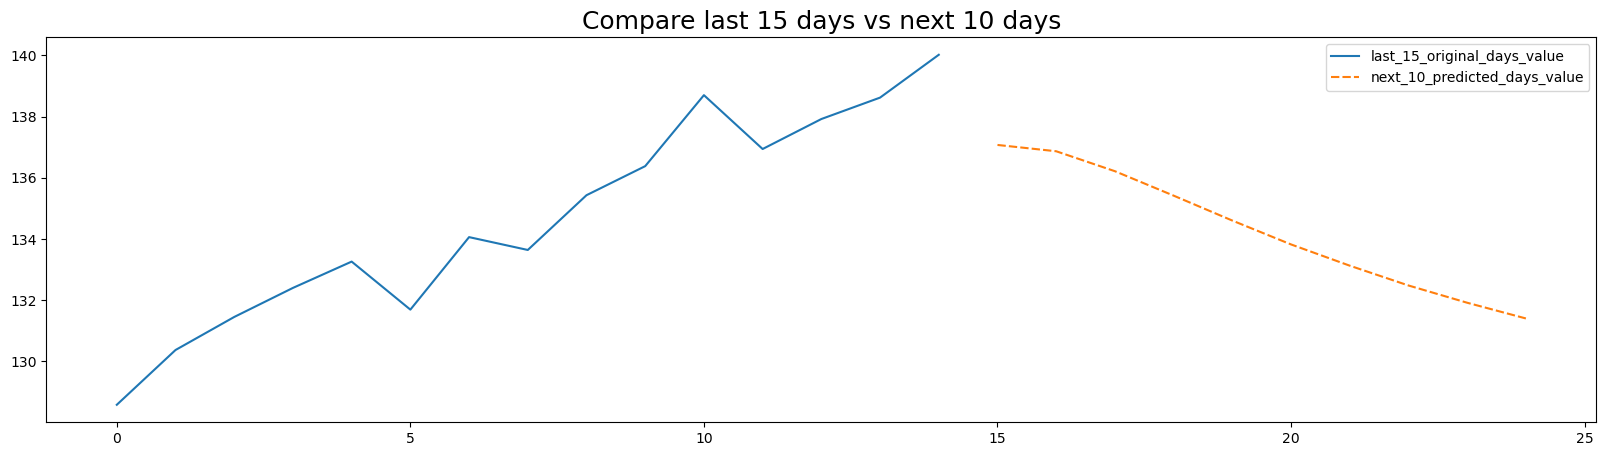

In [175]:
#Create array of last 15 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10

while(i<pred_days): 
  if(len(temp_input)>time_step):
    x_input=np.array(temp_input[1:]) #print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1) 
    yhat = model.predict(np.expand_dims(x_input, 2)) #print("{} day output {}".format(i,yhat)) 
    temp_input.extend(yhat[0]) 
    temp_input=temp_input[1:] 
    
    lst_output.extend(yhat.tolist()) 
    i=i+1 

  else: 
    yhat = model.predict(np.expand_dims(x_input, 2)) 
    temp_input.extend(yhat[0]) 

    lst_output.extend(yhat.tolist()) 
    i=i+1 

print("Output of predicted next days: ", len(lst_output))
print("Output of predicted next days: ",lst_output)

#List of days used for comparision

last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
len(last_original_days_value)

#Empty dataframe for plot
temp_mat = np.empty((len(last_days)+pred_days,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

#Save last 15 days plus next 10 days for comparision
last_original_days_value[0:time_step] = scaler.inverse_transform(closep[len(closep)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
new_pred_plot = pd.DataFrame({'last_15_original_days_value':last_original_days_value, 'next_10_predicted_days_value':next_predicted_days_value})

#plot
plt.figure(figsize=(20,5))
sns.lineplot(data=new_pred_plot)
plt.title("Compare last 15 days vs next 10 days",fontsize=18)


In [192]:
data = [apple,google]

data

[0        16.398514
 1        16.700975
 2        17.094236
 3        17.410784
 4        17.259245
            ...    
 2511    189.710007
 2512    189.690002
 2513    191.449997
 2514    190.639999
 2515    191.309998
 Name: Adj Close, Length: 2516, dtype: float64,
 0        26.050606
 1        26.361441
 2        26.478502
 3        26.390831
 4        26.263557
            ...    
 2511    138.699997
 2512    136.940002
 2513    137.919998
 2514    138.619995
 2515    140.020004
 Name: Adj Close, Length: 2516, dtype: float64]

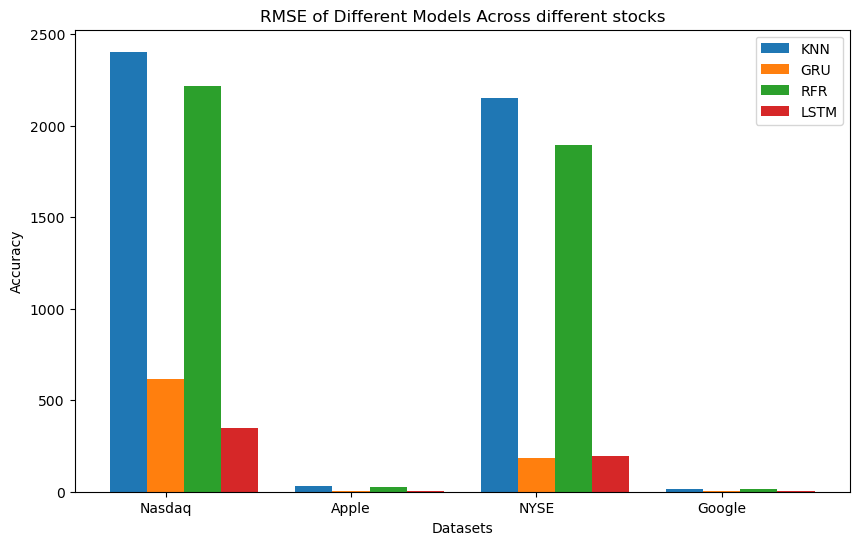

In [202]:
import matplotlib.pyplot as plt

# Assuming you have data for four models and four datasets
# Replace this with your actual data

models = ['KNN', 'GRU', 'RFR', 'LSTM']
datasets = ['Nasdaq', 'Apple', 'NYSE', 'Google']

# Example data (replace with your actual data)
accuracy_data = [
    [2403.69, 31.93, 2150.31, 15.50],  # Model1
    [615.37, 3.33, 182.34, 3.86],  # Model2
    [2217.93, 26.62, 1896.71, 14.67],  # Model3
    [347.57, 5.75, 194.67, 4.26]   # Model4
]

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.2

# Plot each model's accuracy for each dataset
for i, model in enumerate(models):
    x_values = [j + i * bar_width for j in range(len(datasets))]
    plt.bar(x_values, accuracy_data[i], width=bar_width, label=model)

# Set the labels and title
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('RMSE of Different Models Across different stocks')

# Set the x-axis ticks and labels
plt.xticks([j + bar_width for j in range(len(datasets))], datasets)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [208]:
df_goog[['Date', 'Adj Close']]

,Date,Adj Close
0,2013-11-25,26.050606
1,2013-11-26,26.361441
2,2013-11-27,26.478502
3,2013-11-29,26.390831
4,2013-12-02,26.263557
...,...,...
2511,2023-11-16,138.699997
2512,2023-11-17,136.940002
2513,2023-11-20,137.919998
2514,2023-11-21,138.619995


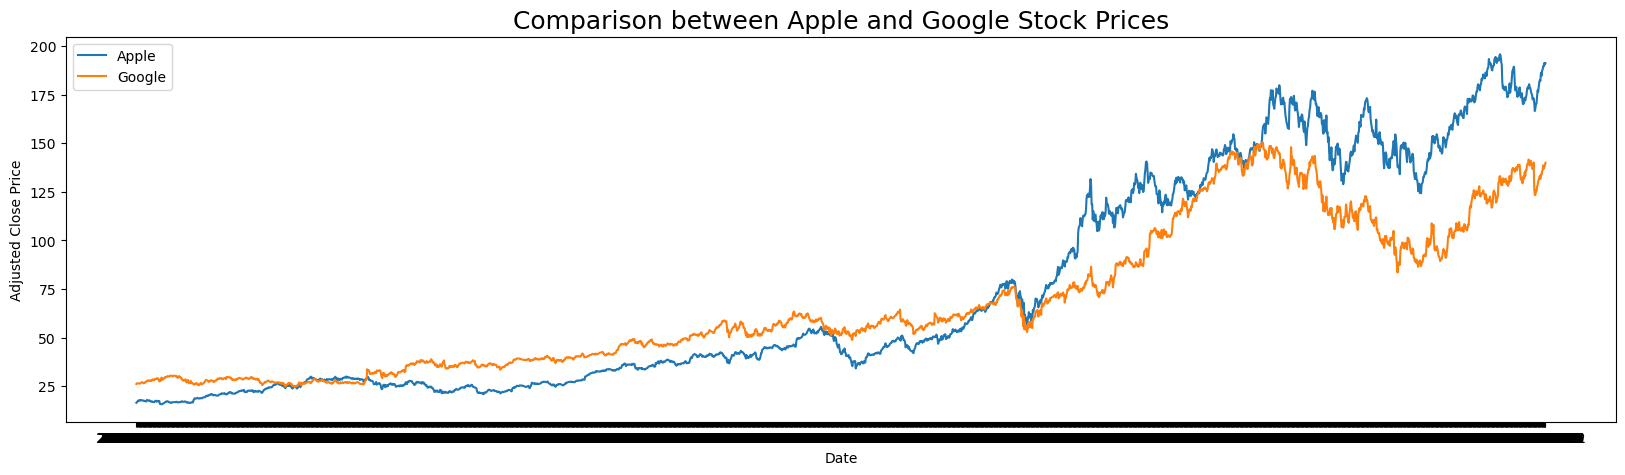

In [210]:
apple = pd.DataFrame(df_apple[['Date','Adj Close']])
google = pd.DataFrame(df_goog[['Date','Adj Close']])

# Combine the dataframes
combined_df = pd.merge(apple, google, on='Date', suffixes=('_Apple', '_Google'))

# Plotting
plt.figure(figsize=(20, 5))
sns.lineplot(x='Date', y='Adj Close_Apple', data=combined_df, label='Apple')
sns.lineplot(x='Date', y='Adj Close_Google', data=combined_df, label='Google')
plt.title("Comparison between Apple and Google Stock Prices", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

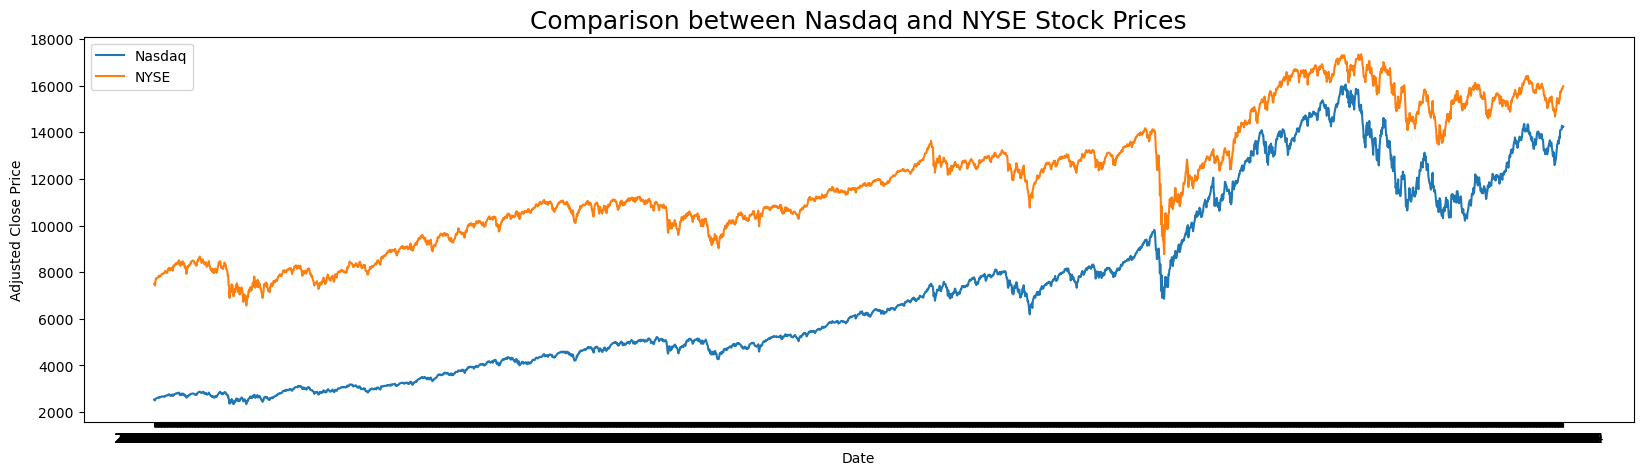

In [220]:
Nasdaq = pd.DataFrame(df_nasdaq[['Date','Adj Close']])
NYSE = pd.DataFrame(df_NYSE[['Date','Adj Close']])

# Combine the dataframes
combined_df = pd.merge(Nasdaq, NYSE, on='Date', suffixes=('_Nasdaq', '_NYSE'))

# Plotting
plt.figure(figsize=(20, 5))
sns.lineplot(x='Date', y='Adj Close_Nasdaq', data=combined_df, label='Nasdaq')
sns.lineplot(x='Date', y='Adj Close_NYSE', data=combined_df, label='NYSE')
#plt.xticks([str(date)[:4] for date in pd.date_range(start='2014-01-01', end='2023-01-01', freq='2A-DEC')])
plt.title("Comparison between Nasdaq and NYSE Stock Prices", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()